State space: Dict('destination': Box(0, 9, (2,), int32), 'fuels': Box(0, 20, (2,), int32), 'has_passenger': MultiBinary(2), 'passenger': Box(0, 9, (2,), int32), 'taxis': Box(0, 9, (2, 2), int32))
Action space: Tuple(Discrete(6), Discrete(6))
Action mask per taxi: [array([ True,  True,  True, False,  True, False]), array([ True, False,  True,  True,  True, False])]
State: {'taxis': array([[8, 9],
       [9, 2]]), 'fuels': array([19, 19]), 'passenger': array([6, 3]), 'destination': array([5, 6]), 'has_passenger': array([0, 0])}
Sampled Actions: (1, 4)
Reward: -3


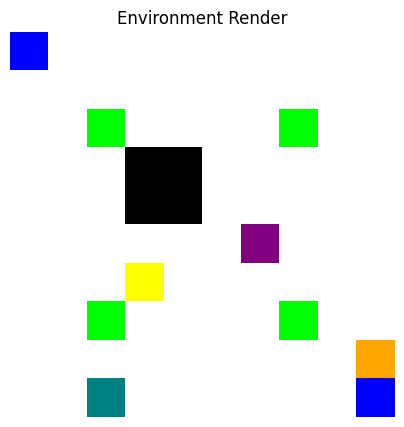

In [11]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from gym import spaces

class ComplexUrbanTaxiEnv(gym.Env):
    """
    A complex, real-world inspired taxi environment with:
      - Multiple taxi agents
      - Fuel limits with refueling stations
      - Obstacles and traffic signals (red/green)
      - Passenger pickup and dropoff
    """
    metadata = {'render.modes': ['human', 'rgb_array']}

    def __init__(self, grid_size=10, num_taxis=2, fuel_limit=20):
        super(ComplexUrbanTaxiEnv, self).__init__()
        self.grid_size = grid_size
        self.num_taxis = num_taxis
        self.fuel_limit = fuel_limit

        # Each taxi can choose among 6 actions:
        # 0: move up, 1: move down, 2: move left, 3: move right, 4: pickup, 5: dropoff
        self.individual_action_space = spaces.Discrete(6)
        self.action_space = spaces.Tuple([self.individual_action_space for _ in range(self.num_taxis)])

        # Observation includes taxi positions, their fuel levels, passenger and destination locations,
        # and a binary flag per taxi indicating if it is carrying the passenger.
        self.observation_space = spaces.Dict({
            "taxis": spaces.Box(low=0, high=self.grid_size-1, shape=(self.num_taxis, 2), dtype=np.int32),
            "fuels": spaces.Box(low=0, high=self.fuel_limit, shape=(self.num_taxis,), dtype=np.int32),
            "passenger": spaces.Box(low=0, high=self.grid_size-1, shape=(2,), dtype=np.int32),
            "destination": spaces.Box(low=0, high=self.grid_size-1, shape=(2,), dtype=np.int32),
            "has_passenger": spaces.MultiBinary(self.num_taxis)
        })

        # Define environmental features:
        self.obstacles = {(3, 3), (3, 4), (4, 3), (4, 4)}  # e.g. a building block in the center
        self.fuel_stations = {(0, 0), (self.grid_size-1, self.grid_size-1)}
        # Traffic signals: each signal is a cell that is either green (True) or red (False)
        self.traffic_signals = {
            (2, 2): True,
            (2, 7): True,
            (7, 2): True,
            (7, 7): True
        }

        self.reset()

    def reset(self, seed=None, options=None):
        # Initialize taxis: assign each a random position and full fuel.
        self.taxis = []
        for _ in range(self.num_taxis):
            pos = [random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)]
            self.taxis.append({"pos": pos, "fuel": self.fuel_limit, "has_passenger": False})
        
        # Randomly set passenger and destination locations.
        self.passenger = [random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)]
        self.destination = [random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)]
        
        self.done = False
        self.history = [ [tuple(taxi["pos"]) for taxi in self.taxis] ]
        return self._get_obs(), {}

    def _get_obs(self):
        taxis_pos = np.array([taxi["pos"] for taxi in self.taxis], dtype=np.int32)
        fuels = np.array([taxi["fuel"] for taxi in self.taxis], dtype=np.int32)
        has_passenger = np.array([1 if taxi["has_passenger"] else 0 for taxi in self.taxis], dtype=np.int32)
        return {
            "taxis": taxis_pos,
            "fuels": fuels,
            "passenger": np.array(self.passenger, dtype=np.int32),
            "destination": np.array(self.destination, dtype=np.int32),
            "has_passenger": has_passenger
        }
    
    def action_mask(self, obs):
        """
        Returns a list of boolean masks—one per taxi—indicating which of the 6 actions are allowed.
        For example, a taxi at the edge cannot move off the grid, and a taxi already carrying a passenger
        cannot pick up another.
        """
        masks = []
        for taxi in self.taxis:
            mask = np.ones(6, dtype=bool)  # Start with all actions allowed
            x, y = taxi["pos"]
            # Disallow moves that would go off the grid
            if x == 0:
                mask[0] = False  # up
            if x == self.grid_size - 1:
                mask[1] = False  # down
            if y == 0:
                mask[2] = False  # left
            if y == self.grid_size - 1:
                mask[3] = False  # right
            # Pickup is only allowed if taxi is NOT already carrying a passenger.
            if taxi["has_passenger"]:
                mask[4] = False
            else:
                mask[5] = False  # dropoff only allowed if taxi has a passenger
            masks.append(mask)
        return masks

    def step(self, actions):
        """
        Expects a tuple of actions (one per taxi). Processes each taxi’s action sequentially.
        Returns a tuple (obs, total_reward, done, info).
        """
        if self.done:
            return self._get_obs(), 0, True, {}

        total_reward = 0
        # Update traffic signals (they may change state randomly)
        self._update_traffic_signals()
        
        for i, action in enumerate(actions):
            taxi = self.taxis[i]
            if taxi["fuel"] <= 0:
                continue  # Skip taxis that are out of fuel.

            x, y = taxi["pos"]
            reward = 0

            # Actions 0-3 correspond to movement.
            if action in [0, 1, 2, 3]:
                new_x, new_y = x, y
                if action == 0:  # move up
                    new_x = x - 1
                elif action == 1:  # move down
                    new_x = x + 1
                elif action == 2:  # move left
                    new_y = y - 1
                elif action == 3:  # move right
                    new_y = y + 1
                
                # Check boundaries and obstacles.
                if 0 <= new_x < self.grid_size and 0 <= new_y < self.grid_size:
                    if (new_x, new_y) not in self.obstacles:
                        # If the cell has a traffic signal and it is red, apply a penalty and prevent movement.
                        if (new_x, new_y) in self.traffic_signals and not self.traffic_signals[(new_x, new_y)]:
                            reward -= 5  # Penalty for running a red light; taxi stays in place.
                        else:
                            taxi["pos"] = [new_x, new_y]
                            reward -= 1  # Cost for moving.
                    else:
                        reward -= 2  # Penalty for bumping into an obstacle.
                else:
                    reward -= 2  # Penalty for an invalid move.
            
            elif action == 4:  # pickup
                # A taxi can pick up the passenger if it is at the same location and no other taxi has picked up.
                if taxi["pos"] == self.passenger and not any(t["has_passenger"] for t in self.taxis):
                    taxi["has_passenger"] = True
                    reward += 10
                else:
                    reward -= 2  # Illegal pickup.
            
            elif action == 5:  # dropoff
                # A taxi can drop off only if it carries the passenger and is at the destination.
                if taxi["has_passenger"] and taxi["pos"] == self.destination:
                    taxi["has_passenger"] = False
                    reward += 20
                    self.done = True  # Episode ends after a successful dropoff.
                else:
                    reward -= 2  # Illegal dropoff.

            # Deduct fuel for taking an action.
            taxi["fuel"] -= 1

            # If a taxi lands on a fuel station, it refuels.
            if tuple(taxi["pos"]) in self.fuel_stations:
                taxi["fuel"] = self.fuel_limit

            total_reward += reward

        self.history.append([tuple(taxi["pos"]) for taxi in self.taxis])
        return self._get_obs(), total_reward, self.done, {}

    def _update_traffic_signals(self):
        # Each traffic signal has a chance to flip its state (e.g., from green to red or vice versa).
        for pos in self.traffic_signals:
            if random.random() < 0.3:
                self.traffic_signals[pos] = not self.traffic_signals[pos]

    def render(self, mode='human'):
        """
        Creates a visual representation of the grid:
          - White background
          - Black cells for obstacles
          - Blue cells for fuel stations
          - Red or green for traffic signals (depending on state)
          - Yellow cell for the passenger and purple for the destination
          - Taxis are drawn in distinct colors.
        """
        # Create an RGB image of the grid.
        grid = np.ones((self.grid_size, self.grid_size, 3), dtype=np.uint8) * 255  # white background
        
        # Draw obstacles.
        for (x, y) in self.obstacles:
            grid[x, y] = [0, 0, 0]
        # Draw fuel stations.
        for (x, y) in self.fuel_stations:
            grid[x, y] = [0, 0, 255]
        # Draw traffic signals.
        for (x, y), state in self.traffic_signals.items():
            grid[x, y] = [0, 255, 0] if state else [255, 0, 0]
        # Draw passenger.
        px, py = self.passenger
        grid[px, py] = [255, 255, 0]
        # Draw destination.
        dx, dy = self.destination
        grid[dx, dy] = [128, 0, 128]
        # Draw taxis in distinct colors.
        taxi_colors = [[255, 165, 0], [0, 128, 128], [128, 128, 0]]
        for i, taxi in enumerate(self.taxis):
            x, y = taxi["pos"]
            grid[x, y] = taxi_colors[i % len(taxi_colors)]
        
        if mode == 'rgb_array':
            return grid
        elif mode == 'human':
            plt.figure(figsize=(5, 5))
            plt.imshow(grid)
            plt.title("Complex Urban Taxi Environment")
            plt.axis('off')
            plt.show()

# -------------------------------
# Testing the new environment:
# -------------------------------

if __name__ == "__main__":
    # Initialize and validate the environment.
    env = ComplexUrbanTaxiEnv(grid_size=10, num_taxis=2, fuel_limit=20)
    obs, _ = env.reset()

    # Print dimensions of state and action space.
    print("State space:", env.observation_space)
    print("Action space:", env.action_space)

    # Get allowed actions for each taxi.
    mask = env.action_mask(obs)
    print("Action mask per taxi:", mask)

    # Sample a random allowed action for each taxi.
    actions = []
    for m in mask:
        allowed_actions = np.where(m)[0]
        actions.append(int(random.choice(allowed_actions)))
    actions = tuple(actions)

    # Take one step.
    next_obs, reward, done, _ = env.step(actions)
    
    # Print output.
    print("State:", next_obs)
    print("Sampled Actions:", actions)
    print("Reward:", reward)

    # Render an environment frame.
    frame = env.render(mode="rgb_array")
    plt.figure(figsize=(5, 5))
    plt.imshow(frame)
    plt.axis("off")
    plt.title("Environment Render")
    plt.show()


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from time import sleep
from IPython.display import clear_output
from PIL import Image

# Function to run animation of an episode
def run_animation(experience_buffer):
    """Function to run animation"""
    time_lag = 0.05  # Delay (in s) between frames
    for experience in experience_buffer:
        # Plot frame
        clear_output(wait=True)
        plt.imshow(experience['frame'])
        plt.axis('off')
        plt.show()

        # Print console output
        print(f"Episode: {experience['episode']}/{experience_buffer[-1]['episode']}")
        print(f"Epoch: {experience['epoch']}/{experience_buffer[-1]['epoch']}")
        print(f"State: {experience['state']}")
        print(f"Action: {experience['action']}")
        print(f"Reward: {experience['reward']}")

        # Pause animation
        sleep(time_lag)

# Function to store the episode as a GIF
def store_episode_as_gif(experience_buffer, path='./', filename='animation2.gif'):
    """Store the episode as a GIF"""
    images = []
    
    # Convert each frame in the experience buffer to an image
    for experience in experience_buffer:
        frame = experience['frame']  # Extract frame
        img = Image.fromarray(frame)  # Convert to image
        images.append(img)

    # Save the images as a GIF
    images[0].save(f"{path}/{filename}", save_all=True, append_images=images[1:], duration=100, loop=0)
    print(f"GIF saved at: {path}/{filename}")

# --- Integrating with ComplexUrbanTaxiEnv ---

class ComplexUrbanTaxiEnv(gym.Env):
    def __init__(self, grid_size=10, num_taxis=2, fuel_limit=20):
        super(ComplexUrbanTaxiEnv, self).__init__()
        self.grid_size = grid_size
        self.num_taxis = num_taxis
        self.fuel_limit = fuel_limit
        self.history = []  # Store the experience buffer

    def step(self, actions):
        next_obs, total_reward, done, _ = super().step(actions)
        
        # Capture the current frame
        frame = self.render(mode="rgb_array")
        
        # Store the current state, action, reward, and frame
        self.history.append({
            'episode': self.episode,  # Example: track episode number
            'epoch': self.epoch,  # Example: track epoch/steps
            'state': next_obs,
            'action': actions,
            'reward': total_reward,
            'frame': frame
        })
        
        return next_obs, total_reward, done, {}

    def reset(self, seed=None, options=None):
        self.episode = 1
        self.epoch = 0
        self.history = []  # Clear history at the start of each episode
        return super().reset(seed, options)

    def render(self, mode='human'):
        return super().render(mode)


NameError: name 'gym' is not defined

Training Random Agent...
Episode 20/100 - Total Reward: -66, Steps: 50
Episode 40/100 - Total Reward: -48, Steps: 50
Episode 60/100 - Total Reward: -54, Steps: 50
Episode 80/100 - Total Reward: -46, Steps: 50
Episode 100/100 - Total Reward: -55, Steps: 50

Training Q-Learning Agent...
Episode 20/100 - Total Reward: -55, Steps: 50
Episode 40/100 - Total Reward: -89, Steps: 50
Episode 60/100 - Total Reward: -50, Steps: 50
Episode 80/100 - Total Reward: -47, Steps: 50
Episode 100/100 - Total Reward: -57, Steps: 50

Training SARSA Agent...
Episode 20/100 - Total Reward: -48, Steps: 50
Episode 40/100 - Total Reward: -48, Steps: 50
Episode 60/100 - Total Reward: -48, Steps: 50
Episode 80/100 - Total Reward: -45, Steps: 50
Episode 100/100 - Total Reward: -44, Steps: 50


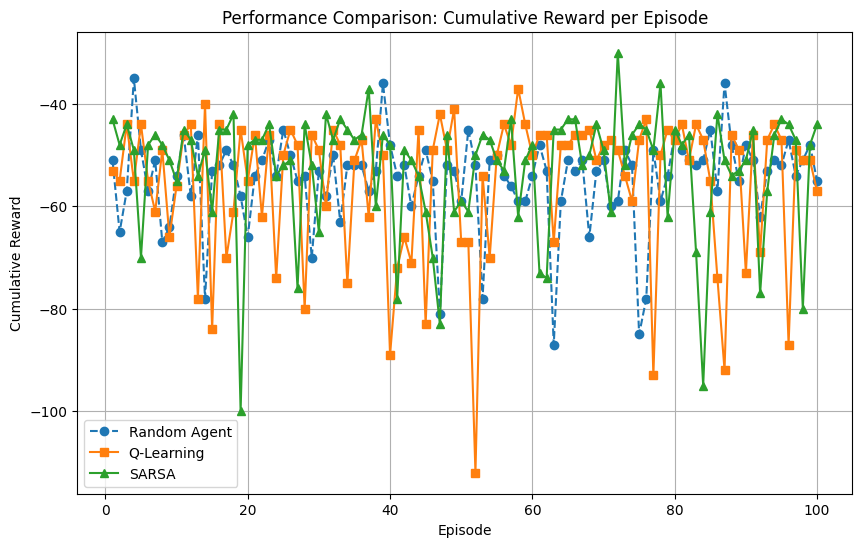

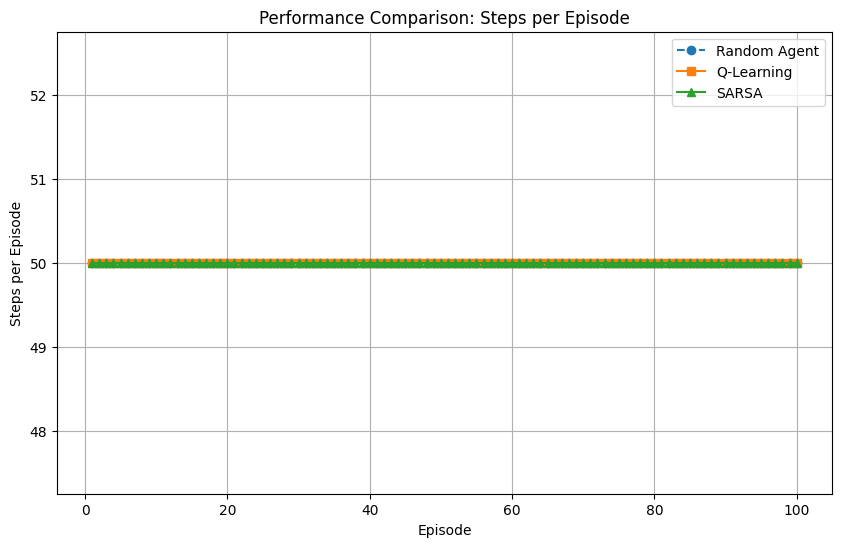

In [2]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from gym import spaces
from time import sleep
from IPython.display import clear_output
from PIL import Image

# =============================================================================
# Custom Environment: ComplexUrbanTaxiEnv
# =============================================================================
class ComplexUrbanTaxiEnv(gym.Env):
    """
    A complex, real-world inspired taxi environment with:
      - Multiple taxi agents
      - Fuel limits with refueling stations
      - Obstacles and traffic signals (red/green)
      - Passenger pickup and dropoff
    """
    metadata = {'render.modes': ['human', 'rgb_array']}

    def __init__(self, grid_size=10, num_taxis=2, fuel_limit=20):
        super(ComplexUrbanTaxiEnv, self).__init__()
        self.grid_size = grid_size
        self.num_taxis = num_taxis
        self.fuel_limit = fuel_limit

        # Each taxi has 6 actions:
        # 0: move up, 1: move down, 2: move left, 3: move right, 4: pickup, 5: dropoff
        self.individual_action_space = spaces.Discrete(6)
        self.action_space = spaces.Tuple([self.individual_action_space for _ in range(self.num_taxis)])

        # Observation includes taxi positions, their fuel, passenger and destination, and a flag indicating if it carries the passenger.
        self.observation_space = spaces.Dict({
            "taxis": spaces.Box(low=0, high=self.grid_size-1, shape=(self.num_taxis, 2), dtype=np.int32),
            "fuels": spaces.Box(low=0, high=self.fuel_limit, shape=(self.num_taxis,), dtype=np.int32),
            "passenger": spaces.Box(low=0, high=self.grid_size-1, shape=(2,), dtype=np.int32),
            "destination": spaces.Box(low=0, high=self.grid_size-1, shape=(2,), dtype=np.int32),
            "has_passenger": spaces.MultiBinary(self.num_taxis)
        })

        # Define environmental features:
        self.obstacles = {(3, 3), (3, 4), (4, 3), (4, 4)}
        self.fuel_stations = {(0, 0), (self.grid_size-1, self.grid_size-1)}
        # Traffic signals with binary state: True for green, False for red.
        self.traffic_signals = {
            (2, 2): True,
            (2, 7): True,
            (7, 2): True,
            (7, 7): True
        }
        
        self.reset()

    def reset(self, seed=None, options=None):
        # Initialize taxis: assign each a random position and full fuel.
        self.taxis = []
        for _ in range(self.num_taxis):
            pos = [random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)]
            self.taxis.append({"pos": pos, "fuel": self.fuel_limit, "has_passenger": False})
        
        # Randomly set passenger and destination locations.
        self.passenger = [random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)]
        self.destination = [random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)]
        
        self.done = False
        self.history = [[tuple(taxi["pos"]) for taxi in self.taxis]]
        return self._get_obs(), {}

    def _get_obs(self):
        taxis_pos = np.array([taxi["pos"] for taxi in self.taxis], dtype=np.int32)
        fuels = np.array([taxi["fuel"] for taxi in self.taxis], dtype=np.int32)
        has_passenger = np.array([1 if taxi["has_passenger"] else 0 for taxi in self.taxis], dtype=np.int32)
        return {
            "taxis": taxis_pos,
            "fuels": fuels,
            "passenger": np.array(self.passenger, dtype=np.int32),
            "destination": np.array(self.destination, dtype=np.int32),
            "has_passenger": has_passenger
        }
    
    def action_mask(self, obs):
        """
        Returns a list of boolean masks—one per taxi—indicating which actions are allowed.
        """
        masks = []
        for taxi in self.taxis:
            mask = np.ones(6, dtype=bool)  # Allow all actions initially.
            x, y = taxi["pos"]
            if x == 0:
                mask[0] = False  # cannot move up
            if x == self.grid_size - 1:
                mask[1] = False  # cannot move down
            if y == 0:
                mask[2] = False  # cannot move left
            if y == self.grid_size - 1:
                mask[3] = False  # cannot move right
            # Pickup is only allowed if taxi is not already carrying a passenger.
            if taxi["has_passenger"]:
                mask[4] = False
            else:
                mask[5] = False  # cannot dropoff if no passenger onboard.
            masks.append(mask)
        return masks

    def step(self, actions):
        """
        Expects a tuple of actions (one per taxi). Each taxi’s action is processed sequentially.
        """
        if self.done:
            return self._get_obs(), 0, True, {}

        total_reward = 0
        # Update traffic signals.
        self._update_traffic_signals()
        
        for i, action in enumerate(actions):
            taxi = self.taxis[i]
            if taxi["fuel"] <= 0:
                continue  # Skip taxis that are out of fuel.

            x, y = taxi["pos"]
            reward = 0

            # Movement actions.
            if action in [0, 1, 2, 3]:
                new_x, new_y = x, y
                if action == 0:  # move up
                    new_x = x - 1
                elif action == 1:  # move down
                    new_x = x + 1
                elif action == 2:  # move left
                    new_y = y - 1
                elif action == 3:  # move right
                    new_y = y + 1
                
                if 0 <= new_x < self.grid_size and 0 <= new_y < self.grid_size:
                    if (new_x, new_y) not in self.obstacles:
                        # Check for red traffic signals.
                        if (new_x, new_y) in self.traffic_signals and not self.traffic_signals[(new_x, new_y)]:
                            reward -= 5  # Penalty for moving into red light cell (taxi stays).
                        else:
                            taxi["pos"] = [new_x, new_y]
                            reward -= 1  # movement cost.
                    else:
                        reward -= 2  # penalty for hitting an obstacle.
                else:
                    reward -= 2  # penalty for invalid move.
            
            elif action == 4:  # pickup action
                if taxi["pos"] == self.passenger and not any(t["has_passenger"] for t in self.taxis):
                    taxi["has_passenger"] = True
                    reward += 10
                else:
                    reward -= 2  # illegal pickup attempt.
            
            elif action == 5:  # dropoff action
                if taxi["has_passenger"] and taxi["pos"] == self.destination:
                    taxi["has_passenger"] = False
                    reward += 20
                    self.done = True  # Episode ends after successful dropoff.
                else:
                    reward -= 2  # illegal dropoff.
            
            # Deduct fuel for action.
            taxi["fuel"] -= 1

            # Refuel if at a fuel station.
            if tuple(taxi["pos"]) in self.fuel_stations:
                taxi["fuel"] = self.fuel_limit

            total_reward += reward

        self.history.append([tuple(taxi["pos"]) for taxi in self.taxis])
        return self._get_obs(), total_reward, self.done, {}

    def _update_traffic_signals(self):
        for pos in self.traffic_signals:
            if random.random() < 0.3:
                self.traffic_signals[pos] = not self.traffic_signals[pos]

    def render(self, mode='human'):
        """
        Creates a visual representation of the grid.
        """
        grid = np.ones((self.grid_size, self.grid_size, 3), dtype=np.uint8) * 255  # white background
        
        # Draw obstacles.
        for (x, y) in self.obstacles:
            grid[x, y] = [0, 0, 0]
        # Draw fuel stations.
        for (x, y) in self.fuel_stations:
            grid[x, y] = [0, 0, 255]
        # Draw traffic signals.
        for (x, y), state in self.traffic_signals.items():
            grid[x, y] = [0, 255, 0] if state else [255, 0, 0]
        # Draw passenger.
        px, py = self.passenger
        grid[px, py] = [255, 255, 0]
        # Draw destination.
        dx, dy = self.destination
        grid[dx, dy] = [128, 0, 128]
        # Draw taxis in distinct colors.
        taxi_colors = [[255, 165, 0], [0, 128, 128], [128, 128, 0]]
        for i, taxi in enumerate(self.taxis):
            x, y = taxi["pos"]
            grid[x, y] = taxi_colors[i % len(taxi_colors)]
        
        if mode == 'rgb_array':
            return grid
        elif mode == 'human':
            plt.figure(figsize=(5, 5))
            plt.imshow(grid)
            plt.title("Complex Urban Taxi Environment")
            plt.axis('off')
            plt.show()

    # --- (Optional) Functions for animation and saving a GIF ---
    def run_animation(self, experience_buffer):
        time_lag = 0.05  # Delay between frames
        for experience in experience_buffer:
            clear_output(wait=True)
            plt.imshow(experience['frame'])
            plt.axis('off')
            plt.show()
            print(f"Episode: {experience['episode']}, Step: {experience['epoch']}")
            print(f"State: {experience['state']}")
            print(f"Action: {experience['action']}")
            print(f"Reward: {experience['reward']}")
            sleep(time_lag)

    def store_episode_as_gif(self, experience_buffer, path='./', filename='animation2.gif'):
        images = []
        for experience in experience_buffer:
            frame = experience['frame']
            img = Image.fromarray(frame)
            images.append(img)
        images[0].save(f"{path}/{filename}", save_all=True, append_images=images[1:], duration=100, loop=0)
        print(f"GIF saved at: {path}/{filename}")

# =============================================================================
# Helper Function: Discretize Observation for Tabular Methods
# =============================================================================
def discretize_state(obs):
    """
    Convert observation dictionary into a discrete tuple.
    Here we consider the following for the first taxi:
      - taxi (x, y) position,
      - fuel,
      - has_passenger flag,
      - passenger (x, y) position,
      - destination (x, y) position.
    """
    taxi = obs["taxis"][0]
    fuel = obs["fuels"][0]
    has_passenger = obs["has_passenger"][0]
    passenger = obs["passenger"]
    destination = obs["destination"]
    return (int(taxi[0]), int(taxi[1]), int(fuel), int(has_passenger),
            int(passenger[0]), int(passenger[1]), int(destination[0]), int(destination[1]))

# =============================================================================
# RL Agents
# =============================================================================

class RandomAgent:
    def get_action(self, state, mask):
        allowed_actions = np.where(mask)[0]
        return int(random.choice(allowed_actions))
    def update(self, state, action, reward, next_state, done, next_mask):
        # Random agent does not learn.
        pass

class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.alpha = alpha      # Learning rate
        self.gamma = gamma      # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.Q = {}  # Q-table: key=(state, action), value=Q-value

    def get_Q(self, state, action):
        return self.Q.get((state, action), 0.0)

    def get_action(self, state, mask):
        # Epsilon-greedy action selection.
        if random.random() < self.epsilon:
            allowed_actions = np.where(mask)[0]
            return int(random.choice(allowed_actions))
        q_values = [self.get_Q(state, a) if mask[a] else -np.inf for a in range(6)]
        return int(np.argmax(q_values))

    def update(self, state, action, reward, next_state, done, next_mask):
        best_next = max([self.get_Q(next_state, a) if next_mask[a] else -np.inf for a in range(6)])
        td_target = reward + (0 if done else self.gamma * best_next)
        td_error = td_target - self.get_Q(state, action)
        self.Q[(state, action)] = self.get_Q(state, action) + self.alpha * td_error

class SARSAAgent:
    def __init__(self, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.alpha = alpha      # Learning rate
        self.gamma = gamma      # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.Q = {}  # Q-table

    def get_Q(self, state, action):
        return self.Q.get((state, action), 0.0)

    def get_action(self, state, mask):
        if random.random() < self.epsilon:
            allowed = np.where(mask)[0]
            return int(random.choice(allowed))
        q_values = [self.get_Q(state, a) if mask[a] else -np.inf for a in range(6)]
        return int(np.argmax(q_values))

    def update(self, state, action, reward, next_state, done, next_mask):
        next_action = self.get_action(next_state, next_mask) if not done else 0
        td_target = reward + (0 if done else self.gamma * self.get_Q(next_state, next_action))
        td_error = td_target - self.get_Q(state, action)
        self.Q[(state, action)] = self.get_Q(state, action) + self.alpha * td_error

# =============================================================================
# Training Loop for a Given Agent
# =============================================================================
def train_agent(agent, env, num_episodes=100, max_steps=50):
    episode_rewards = []
    episode_steps = []
    for episode in range(num_episodes):
        obs, _ = env.reset()
        state = discretize_state(obs)
        total_reward = 0
        steps = 0
        done = False

        while not done and steps < max_steps:
            # Get allowed actions for taxi 0 (our controlled taxi).
            masks = env.action_mask(obs)
            mask0 = masks[0]
            action0 = agent.get_action(state, mask0)
            # For other taxis, choose random allowed actions.
            actions = [action0]
            for i in range(1, env.num_taxis):
                mask_i = masks[i]
                allowed_actions = np.where(mask_i)[0]
                actions.append(int(random.choice(allowed_actions)))
            actions = tuple(actions)

            next_obs, reward, done, _ = env.step(actions)
            next_state = discretize_state(next_obs)
            next_mask = env.action_mask(next_obs)[0]  # mask for taxi 0 in the next state

            agent.update(state, action0, reward, next_state, done, next_mask)

            state = next_state
            obs = next_obs
            total_reward += reward
            steps += 1

        episode_rewards.append(total_reward)
        episode_steps.append(steps)
        # Optional: print progress every 20 episodes.
        if (episode + 1) % 20 == 0:
            print(f"Episode {episode + 1}/{num_episodes} - Total Reward: {total_reward}, Steps: {steps}")
    return episode_rewards, episode_steps

# =============================================================================
# Main: Train and Compare Agents
# =============================================================================
if __name__ == "__main__":
    num_episodes = 100
    env = ComplexUrbanTaxiEnv(grid_size=10, num_taxis=2, fuel_limit=20)

    # Initialize agents.
    random_agent = RandomAgent()
    q_agent = QLearningAgent(alpha=0.1, gamma=0.99, epsilon=0.1)
    sarsa_agent = SARSAAgent(alpha=0.1, gamma=0.99, epsilon=0.1)

    print("Training Random Agent...")
    random_rewards, random_steps = train_agent(random_agent, env, num_episodes)
    
    print("\nTraining Q-Learning Agent...")
    q_rewards, q_steps = train_agent(q_agent, env, num_episodes)
    
    print("\nTraining SARSA Agent...")
    sarsa_rewards, sarsa_steps = train_agent(sarsa_agent, env, num_episodes)

    # =============================================================================
    # Plot Comparison of Agents
    # =============================================================================
    episodes = np.arange(1, num_episodes + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, random_rewards, label="Random Agent", linestyle='--', marker='o')
    plt.plot(episodes, q_rewards, label="Q-Learning", linestyle='-', marker='s')
    plt.plot(episodes, sarsa_rewards, label="SARSA", linestyle='-', marker='^')
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Reward")
    plt.title("Performance Comparison: Cumulative Reward per Episode")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # (Optional) Plot steps per episode as a secondary metric.
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, random_steps, label="Random Agent", linestyle='--', marker='o')
    plt.plot(episodes, q_steps, label="Q-Learning", linestyle='-', marker='s')
    plt.plot(episodes, sarsa_steps, label="SARSA", linestyle='-', marker='^')
    plt.xlabel("Episode")
    plt.ylabel("Steps per Episode")
    plt.title("Performance Comparison: Steps per Episode")
    plt.legend()
    plt.grid(True)
    plt.show()
